<a href="https://colab.research.google.com/github/Pavani-Jyothirmai/Spam-SMS-Detection/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Spam SMS Detection**

In this project, I built a machine learning model to classify SMS messages as spam or non-spam. The dataset consists of labeled messages, where spam messages are marked as 1 and non-spam (ham) messages as 0.  

To preprocess the text data, I applied techniques such as text cleaning, stopword removal, and TF-IDF vectorization. I trained multiple classification models, including Logistic Regression, Naïve Bayes, SVM, Random Forest, and Gradient Boosting, and evaluated their performance based on accuracy. The SVM model performed the best and was used for final testing to ensure accurate spam detection.

**Dataset**

The dataset consists of **5,572 SMS messages** categorized as **spam** or **ham** (Non-Spam). It contains **two columns**: one for the label and another for the message content. This dataset is commonly used for SMS spam detection research and serves as the foundation for training classification models.

**Import Required Libraries**

In [16]:
import os
import re
import pickle
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")


 Download Required NLTK Resources

In [17]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Load the Dataset**

In [18]:
df = pd.read_csv("/content/spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']

# Convert labels to binary values (spam = 1, Non-Spam = 0)
df['label'] = df['label'].map({'spam': 1, 'Non-Spam': 0})

# Display dataset
print(df.head())
print("\nDataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Dataset Shape: (5572, 2)

Missing Values:
 label      0
message    0
dtype: int64


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   int64 
 1   message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


**Data Pre-Processing**

To prepare the SMS messages for classification, several natural language processing (NLP) techniques were applied. First, all text was converted to lowercase to maintain uniformity. Special characters, numbers, and extra spaces were removed to clean the data. The messages were then tokenized, breaking them down into individual words. To improve efficiency, stopwords (common words that do not contribute to classification) were removed. Finally, lemmatization was performed to reduce words to their base form, ensuring a more meaningful representation of the text. The processed text was stored in a new column, making it ready for model training.

In [20]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]

    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Apply preprocessing
df['cleaned_message'] = df['message'].apply(preprocess_text)

# Display preprocessed messages
print(df[['message', 'cleaned_message']].head())


                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4           nah dont think go usf life around though  


**Data analysis**

To understand the dataset better, exploratory data analysis (EDA) was performed. A class distribution plot was generated to visualize the number of spam and non-spam messages. Additionally, a histogram of message lengths was plotted to analyze the distribution of message lengths. Word clouds were also created separately for spam and ham messages, highlighting the most frequently occurring words in each category. These visualizations provide insights into the characteristics of the messages and help in feature engineering for classification.

 Check Class Distribution

<ipython-input-8-10ba6ee66806>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="viridis")


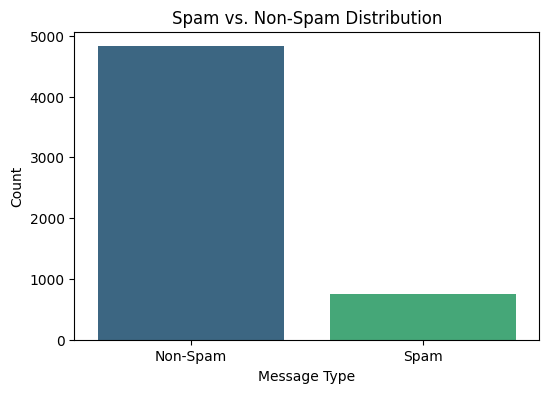

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count spam vs. non-spam messages
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'], palette="viridis")
plt.xticks([0, 1], ['Non-Spam', 'Spam'])
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.title("Spam vs. Non-Spam Distribution")
plt.show()


Check Message Length Distribution

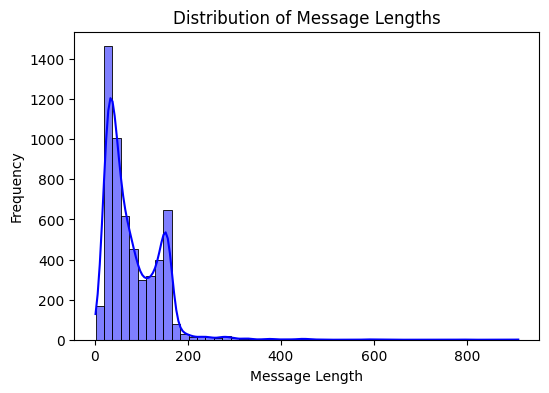

In [7]:
df['message_length'] = df['message'].apply(len)

# Visualize message length distribution
plt.figure(figsize=(6,4))
sns.histplot(df['message_length'], bins=50, kde=True, color="blue")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.title("Distribution of Message Lengths")
plt.show()


Most Common Words in Spam & Ham Messages

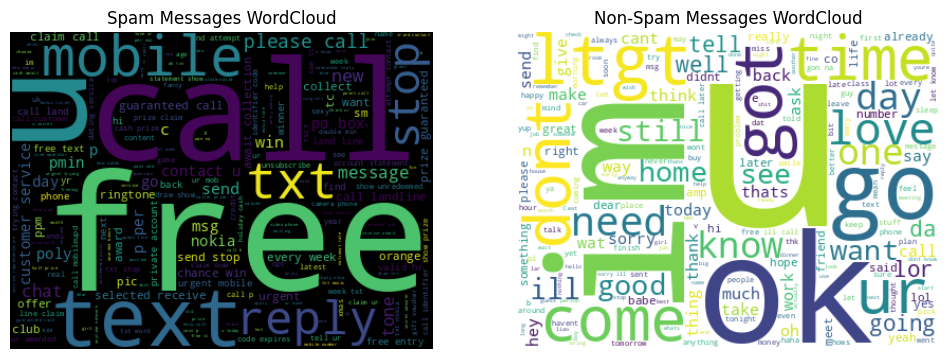

In [13]:
from collections import Counter
from wordcloud import WordCloud

# Get words from spam & ham messages
spam_words = " ".join(df[df['label'] == 1]['cleaned_message'])
Non_Spam_words = " ".join(df[df['label'] == 0]['cleaned_message'])

# Generate Word Clouds
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
spam_wc = WordCloud(width=400, height=300, background_color="black").generate(spam_words)
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Spam Messages WordCloud")

plt.subplot(1,2,2)
Non_Spam_wc = WordCloud(width=400, height=300, background_color="white").generate(Non_Spam_words)
plt.imshow(Non_Spam_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Non-Spam Messages WordCloud")

plt.show()


**Feature Extraction(Convert Text to TF-IDF Features)**

To transform the processed text into a format suitable for machine learning models, TF-IDF (Term Frequency-Inverse Document Frequency) vectorization was applied. The TfidfVectorizer was used to convert the cleaned text into a numerical representation, capturing the importance of words within the dataset. A maximum of 5000 features was selected to maintain efficiency while preserving meaningful information. The resulting feature matrix (X) was used as input for training models, while the labels (y) represented whether a message was spam or not.









In [21]:
# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_message']).toarray()
y = df['label']

# Save the vectorizer
os.makedirs("models", exist_ok=True)
pickle.dump(vectorizer, open("models/tfidf_vectorizer.pkl", "wb"))


**Train-Test Split**

The dataset is split into 80% training and 20% testing to train the model and evaluate its performance consistently.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Train & Evaluate Different Models**

**Naïve Bayes**

In [24]:
# Train Naïve Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test)

# Accuracy
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naïve Bayes Accuracy: {nb_accuracy:.4f}")

# Classification Report
print(classification_report(y_test, y_pred_nb))


Naïve Bayes Accuracy: 0.9704
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       0.99      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



**Logistic Regression**

In [25]:
# Train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Classification Report
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9489
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.65      0.77       150

    accuracy                           0.95      1115
   macro avg       0.95      0.82      0.87      1115
weighted avg       0.95      0.95      0.94      1115



**Support Vector Machine (SVM)**

In [26]:
# Train SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Accuracy
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

# Classification Report
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9776
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



**Random Forest**

In [27]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Classification Report
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9758
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.82      0.90       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115



**Gradient Boosting**

In [29]:
# Train Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predict
y_pred_gb = gb_model.predict(X_test)

# Accuracy
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")

# Classification Report
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.9632
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       0.98      0.74      0.84       150

    accuracy                           0.96      1115
   macro avg       0.97      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115



**Compare Model Performances**


Model Accuracy Comparison:
                      Accuracy
Naïve Bayes          0.970404
Logistic Regression  0.948879
SVM                  0.977578
Random Forest        0.975785
Gradient Boosting    0.963229


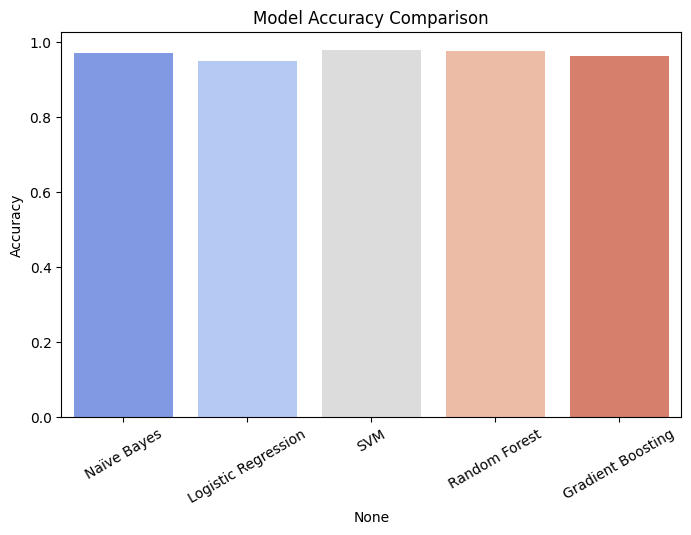

In [30]:
# Store accuracy results
model_accuracies = {
    "Naïve Bayes": nb_accuracy,
    "Logistic Regression": lr_accuracy,
    "SVM": svm_accuracy,
    "Random Forest": rf_accuracy,
    "Gradient Boosting": gb_accuracy
}

# Convert to DataFrame
accuracy_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Accuracy'])
print("\nModel Accuracy Comparison:\n", accuracy_df)

# Plot accuracy comparison
plt.figure(figsize=(8,5))
sns.barplot(x=accuracy_df.index, y=accuracy_df['Accuracy'], palette='coolwarm')
plt.xticks(rotation=30)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


**Evaluate on Test Data**

SVM achieved the highest accuracy among all trained models, so I used it for final testing to ensure accurate spam detection

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



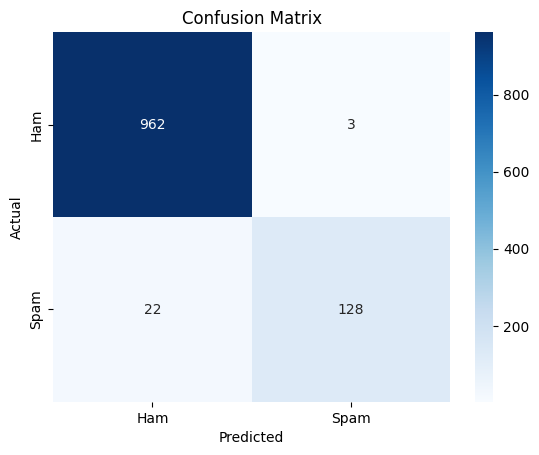

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = svm_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Print confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**Test on New SMS Messages**

In [34]:
# Function to predict new messages
def predict_sms(message, model, vectorizer):
    cleaned_message = preprocess_text(message)
    message_vectorized = vectorizer.transform([cleaned_message])
    message_dense = message_vectorized.toarray()
    prediction = model.predict(message_dense)[0]
    return "Spam" if prediction == 1 else "Non-Spam"

# Test with sample messages
sample_sms = ["Congratulations! You have won a lottery of $500. Claim now!",
              "Hey, are we meeting tomorrow?"]

for sms in sample_sms:
    print(f"Message: {sms} -> Prediction: {predict_sms(sms, svm_model, vectorizer)}")


Message: Congratulations! You have won a lottery of $500. Claim now! -> Prediction: Spam
Message: Hey, are we meeting tomorrow? -> Prediction: Non-Spam


 **Summary**  

In this project, I developed a Spam SMS Detection model using machine learning techniques. The dataset consists of labeled SMS messages categorized as spam or non-spam. I applied text preprocessing techniques such as text cleaning, stopword removal, and TF-IDF vectorization to convert the raw messages into a structured format suitable for model training. I then trained multiple classification models, including Logistic Regression, Naïve Bayes, SVM, Random Forest, and Gradient Boosting. After evaluating the models based on accuracy, **SVM achieved the highest accuracy of 97.7%**. Therefore, I used the SVM model for final testing. To test the model, I provided sample SMS messages, transformed them using the trained TF-IDF vectorizer, and predicted whether they were spam or non-spam using the SVM model. The model successfully classified the messages, ensuring accurate spam detection.